## LLM: KV Caching for Faster Inference

In [1]:
import torch
import matplotlib.pyplot as plt
import time
import logging

from transformers import AutoTokenizer, AutoModelForCausalLM


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

if torch.cuda.is_available():
    logger.info("Using GPU")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    logger.info("Using MPS")
    device = torch.device("mps")
else:
    logger.info("Using CPU")
    device = torch.device("cpu")
device

INFO:__main__:Using MPS


device(type='mps')

## Helper functions

In [2]:
def generate_token(ins: dict, model) -> (torch.Tensor, torch.Tensor):
    with torch.no_grad():
        _output = model(**ins)

    _next_token = _output.logits[0, -1, :].argmax()
    return _output, _next_token

## Implementing KV Caching Techinique

In [3]:
tokeniser = AutoTokenizer.from_pretrained("openai-community/gpt2")
gpt2 = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
gpt2

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [4]:
prompt = "I woke up to the rain and as I looked outside the window"
inputs = tokeniser(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[1722, 1909,  318,  257, 3502,  290,  314,  561,  588,  284,  467, 3187,
          257]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [5]:
output, next_token = generate_token(inputs, gpt2)
logger.info(f"Next token is: {next_token} and its value is '{tokeniser.decode(next_token)}'")

INFO:__main__:Next token is: 1545 and its value is ' friend'


In [6]:
_top_k = torch.topk(output.logits[0, -1, :], k=10)
_predictions = [tokeniser.decode(tk) for tk in _top_k.indices]
logger.info(_predictions)

INFO:__main__:[' friend', ' few', ' couple', ' local', ' family', ' little', ' church', ' lot', ' restaurant', ' place']


### Usual Process

In [7]:
inputs_t1 = {
    "input_ids": torch.cat([inputs["input_ids"], next_token.view(1, 1)], dim=1),
    "attention_mask": torch.cat([inputs["attention_mask"], torch.tensor(1).view(1, 1)], dim=1),
}
inputs_t1

{'input_ids': tensor([[1722, 1909,  318,  257, 3502,  290,  314,  561,  588,  284,  467, 3187,
           257, 1545]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

INFO:__main__:Time taken to generate 100 tokens: 202.82621455192566 s


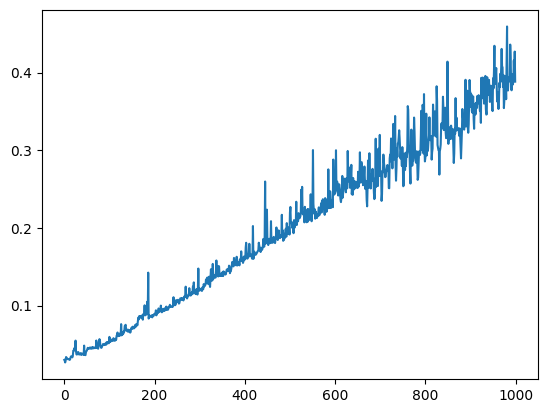

In [8]:
generated_tokens = []
inputs_tx = inputs
durations_s = []
for _ in range(1000):
    t0 = time.time()
    _, next_token_id = generate_token(inputs_tx, gpt2)
    durations_s.append(time.time() - t0)
    
    inputs_tx = {
        "input_ids": torch.cat([inputs_tx["input_ids"], next_token_id.view(1, 1)], dim=1),
        "attention_mask": torch.cat([inputs_tx["attention_mask"], torch.tensor(1).view(1, 1)], dim=1),
    }
    
    next_token = tokeniser.decode(next_token_id)
    generated_tokens.append(next_token)

logger.info(f"Time taken to generate 1000 tokens: {sum(durations_s)} s")
plt.plot(durations_s)
plt.show()

### Implementing KV Caching

INFO:__main__:Time taken to generate 100 tokens with KC Caching: 21.2228786945343 s


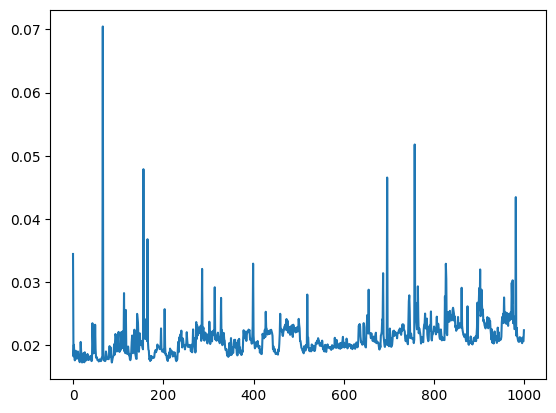

In [9]:
generated_tokens = []
inputs_tx = inputs
durations_cached_s = []
for _ in range(1000):
    t0 = time.time()
    output, next_token_id = generate_token(inputs_tx, gpt2)
    durations_cached_s.append(time.time() - t0)
    
    inputs_tx = {
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat(
            [inputs_tx["attention_mask"], torch.tensor([[1]])],
            dim=1),
        "past_key_values": output.past_key_values,
    }
    
    next_token = tokeniser.decode(next_token_id)
    generated_tokens.append(next_token)

logger.info(f"Time taken to generate 1000 tokens with KC Caching: {sum(durations_cached_s)} s")
plt.plot(durations_cached_s)
plt.show()